In [184]:
# importing all libraries
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import collections
from sklearn import preprocessing
from sklearn.metrics import precision_recall_fscore_support
from sklearn.tree import DecisionTreeClassifier
label_encoder = preprocessing.LabelEncoder()

In [185]:
# reading data from local storage
train_data = pd.read_csv("loan_train.csv")
test_data = pd.read_csv("loan_test.csv")

# get the first row
row = train_data.iloc[0]
column_labels = train_data.columns.values
nan_labels = []

# if data type of the position variable is Nan, record it
for label in column_labels:
    res = row[label]
    if res != res:
        nan_labels.append(label)

u_column_labels = []
for label in column_labels:
    if label in nan_labels:
        continue
    else:
        u_column_labels.append(label)
column_labels = u_column_labels

# drop Nan columns
train_data = train_data.drop(columns=nan_labels)
test_data = test_data.drop(columns=nan_labels)

# Dropping the rows which have loan status as current
Dropping_rows = train_data[train_data.loan_status=='Current'].index
train_data = train_data.drop(Dropping_rows)
Dropping_rows = test_data[test_data.loan_status=='Current'].index
test_data = test_data.drop(Dropping_rows)

In [186]:
# function to remove unique columns
def unique_cols(df):
    a = df.to_numpy()
    return (a[0] == a).all(0)
res = unique_cols(train_data)
u_column_labels = []
unique_labels = []
for i in range(len(column_labels)):
    if not res[i]:
        u_column_labels.append(column_labels[i])
    else:
        unique_labels.append(column_labels[i])
column_labels = u_column_labels
train_data = train_data.drop(columns=unique_labels)
test_data = test_data.drop(columns=unique_labels)

In [187]:
print(train_data.info())
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24301 entries, 0 to 24998
Data columns (total 46 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          24301 non-null  int64  
 1   member_id                   24301 non-null  int64  
 2   loan_amnt                   24301 non-null  int64  
 3   funded_amnt                 24301 non-null  int64  
 4   funded_amnt_inv             24301 non-null  float64
 5   term                        24301 non-null  object 
 6   int_rate                    24301 non-null  object 
 7   installment                 24301 non-null  float64
 8   grade                       24301 non-null  object 
 9   sub_grade                   24301 non-null  object 
 10  emp_title                   24295 non-null  object 
 11  emp_length                  24261 non-null  object 
 12  home_ownership              24301 non-null  object 
 13  annual_inc                  243

In [188]:
train_data.reset_index(drop=True)
test_data.reset_index(drop=True)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,chargeoff_within_12_mths,pub_rec_bankruptcies,tax_liens
0,1001205,1227186,4200,4200,4200.0,36 months,6.62%,128.96,A,A2,...,0.00000,0.0,0.000,14-Nov,132.82,16-May,0.0,0.0,0.0,0.0
1,850106,1061893,1325,1325,1325.0,36 months,13.49%,44.96,C,C2,...,14.93661,28.5,0.285,14-May,44.96,14-Sep,0.0,0.0,0.0,0.0
2,444243,541365,10000,10000,9975.0,36 months,8.94%,317.72,A,A5,...,0.00000,0.0,0.000,10-Feb,9337.10,16-May,0.0,0.0,0.0,0.0
3,741007,938805,6000,6000,6000.0,60 months,16.49%,147.48,D,D3,...,0.00000,0.0,0.000,16-May,147.02,16-May,0.0,0.0,0.0,0.0
4,572468,736352,25000,25000,25000.0,36 months,15.21%,869.21,D,D2,...,0.00000,0.0,0.000,13-Sep,960.31,16-May,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14271,98276,98268,5400,5400,200.0,36 months,7.75%,168.60,A,A3,...,0.00000,0.0,0.000,10-Jul,169.09,13-Dec,NaN,NaN,NaN,NaN
14272,93277,93254,3000,3000,950.0,36 months,8.70%,94.98,B,B1,...,0.00000,0.0,0.000,10-Jul,97.45,10-Jul,NaN,NaN,NaN,NaN
14273,92676,92671,5000,5000,150.0,36 months,8.07%,156.84,A,A4,...,0.00000,0.0,0.000,10-Jul,157.31,7-Jun,NaN,NaN,NaN,NaN
14274,90395,90390,5000,5000,1325.0,36 months,8.07%,156.84,A,A4,...,0.00000,0.0,0.000,8-Apr,0.00,7-Jun,NaN,NaN,NaN,NaN


In [189]:
# these columns are identified as waste of computation, 
# Either has one unique value or having a majority element which is dominating all the rest
labels_to_remove = ['last_pymnt_amnt', 'last_credit_pull_d', 'collection_recovery_fee', 'chargeoff_within_12_mths', 'tax_liens' , 'total_pymnt_inv', 'total_rec_late_fee', 'collections_12_mths_ex_med', 'last_pymnt_d', 'inq_last_6mths', 'delinq_2yrs', 'total_rec_int' , 'funded_amnt', 'recoveries' , 'funded_amnt_inv']
train_data = train_data.drop(columns=labels_to_remove)
test_data = test_data.drop(columns=labels_to_remove)

In [190]:
test_data = test_data.dropna(axis=0)
train_data = train_data.dropna(axis=0)

# using label encoding to manipulate the datatypes which are other than floats
column_labels = train_data.columns.values
row = train_data.iloc[0]
to_be_label_encoded = []
for label in column_labels:
    res = row[label]
    if isinstance(res,str):
        to_be_label_encoded.append(label)

for label in to_be_label_encoded:
    train_data[label] = label_encoder.fit_transform(train_data[label])
    test_data[label] = label_encoder.fit_transform(test_data[label])

for label in column_labels:
    res = row[label]
    print(type(res))
    
print(train_data.info())
print(test_data.info())

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'str'>
<class 'str'>
<class 'numpy.float64'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'numpy.float64'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'numpy.float64'>
<class 'str'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'str'>
<class 'numpy.int64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15888 entries, 0 to 24998
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    15888 non-null  int64  
 1   member_id             15888 non-null  int64  
 2   loan_amnt             15888 non-null  int64  
 3   term                  15888 non-null  int64  
 4   int_rate              15888 no

In [191]:
# splitting X_train,X_test,y_train,y_test
result = 'loan_status'
y_train = train_data[result]
y_test = test_data[result]
X_train = train_data.drop(columns=result)
X_test = test_data.drop(columns=result)

In [192]:
# Using Sklearn Gradient Boosting classifier
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9791851757837289

In [193]:
clf = GradientBoostingClassifier(n_estimators=500, learning_rate=0.6,max_depth=10).fit(X_train, y_train)
y_pred = clf.predict(X_test)
precision,recall,f_score,nan = precision_recall_fscore_support(y_test, y_pred, average='macro')
print("Accuracy : ",clf.score(X_test, y_test))
print("Precision : ",precision)
print("Recall : ",recall)

Accuracy :  0.9906079451707069
Precision :  0.9902622310276867
Recall :  0.9712843880195519


In [203]:
# effect of trees in random forest
estimators = [100,200,300,400]
time_taken = []
accuracy = []

# loop over the estimators and observe the accuracy and time taken
for estimator in estimators:
    start = time.time()
    clf = GradientBoostingClassifier(n_estimators=estimator,learning_rate=0.5).fit(X_train, y_train)
    accuracy.append(clf.score(X_test,y_test))
    time_taken.append(time.time()-start)

print("Accuracy : ", accuracy)
print("Time Taken : ",time_taken)

Accuracy :  [0.9855311587764944, 0.986165757075771, 0.9906079451707069, 0.9906079451707069]
Time Taken :  [6.787179231643677, 13.06709623336792, 19.666242599487305, 26.19341540336609]


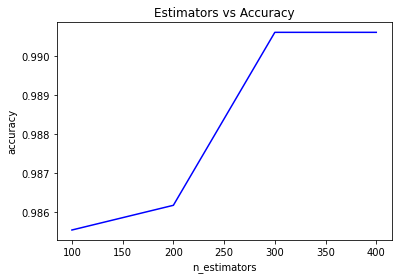

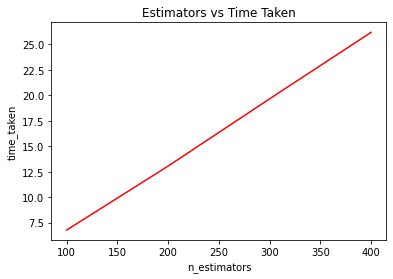

In [204]:
# visualising data recorded

# N_estimators vs Accuracy
plt.plot(estimators,accuracy,color='b')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.title('Estimators vs Accuracy')
plt.show()

# N_estimators vs Time Taken
plt.plot(estimators,time_taken,color='r')
plt.xlabel('n_estimators')
plt.ylabel('time_taken')
plt.title('Estimators vs Time Taken')
plt.show()

In [205]:
# Decision Tree
decision_tree_model = DecisionTreeClassifier(criterion="entropy")
decision_tree_model.fit(X_train,y_train)
y_pred = decision_tree_model.predict(X_test)
precision,recall,f_score,nan = precision_recall_fscore_support(y_test, y_pred, average='macro')
print("Accuracy : ",decision_tree_model.score(X_test,y_test))
print("Precision : ",precision)
print("recall : ",recall)

Accuracy :  0.9854042391166392
Precision :  0.9714219913751554
recall :  0.9689849424269265
